In [11]:
def compute_gradcam_figure(path, zoom, threshold, verbose=True):
    exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom)
    img = exp_img.unsqueeze(0)
    # get the most likely prediction of the model
    pred = model_gradcam(img.to(device))
    fp_pred = (torch.sigmoid(pred) > 0.5).squeeze()

    fp_index_arr = fp_pred.nonzero().detach().cpu().numpy().squeeze()

    mask_list = list()
    if verbose:
        for class_index in tqdm(fp_index_arr):
                mask = np.array(gradcam(model_gradcam, img, class_index, device=device))

                mask = (mask > threshold)*mask
                mask_list.append(mask)
    else:
        for class_index in fp_index_arr:
                mask = np.array(gradcam(model_gradcam, img, class_index, device=device))

                mask = (mask > threshold)*mask
                mask_list.append(mask)

    mask_list = np.array(mask_list)
    mask_mean = mask_list.mean(axis=0)
    mask_normalized = mask_mean/np.max(mask_mean)


    # Convert NumPy array to PIL Image
    image_pil = Image.fromarray((mask_normalized * 255).astype(np.uint8))

    # Resize PIL Image
    new_size = (exp_img.size(2), exp_img.size(2))   # (width, height)
    image_pil_resized = image_pil.resize(new_size)

    # Convert PIL Image back to NumPy array
    image_array_resized = np.array(image_pil_resized)
    
    return exp_img, image_array_resized

def load_jmol_image(cid, dimension=[224,224], zoom=1):
    if USER=='manuel':
        path = f'/home/{USER}/QUAM-AFM/QUAM/JMOL_IMAGES/{cid}/{cid}.png' ##Mustang
    else:
        path = f'/scratch/dataset/quam/JMOL_IMAGES/{cid}/{cid}.png' ##Rocinante
    jmol_image = Image.open(path)
     # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    
    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))
    
    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)
    
    return jmol_image_array


def load_exp_img_stack(path, dimensions=[224,224], zoom=1):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:
        
        im_list.append(Image.open(im_path).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    #normalize = transforms.Normalize(
    #    mean=[0.1321, 0.1487, 0.1689, 0.1983, 0.2229, 0.2591, 0.3430, 0.4580, 0.5787, 0.6887],
    #    std=[0.0853, 0.0853, 0.0883, 0.0942, 0.0969, 0.1066, 0.1419, 0.1840, 0.2144, 0.2215]) #this is for K-1



    normalize = transforms.Normalize(
        mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
        std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders
    
    tensor_stack = normalize(tensor_stack)

    return tensor_stack



class EfficientNet_GradCAM(nn.Module):
    def __init__(self, pretrained_model):
        super(EfficientNet_GradCAM, self).__init__()

        # Get pretrained model
        self.efficientnet = pretrained_model

        # disect the network to access its last convolutional layer
        self.features_conv = self.efficientnet.features

        # add the average global pool
        self.avg_pool = self.efficientnet.avgpool

        # get the classifier of the vgg19
        self.classifier = self.efficientnet.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # don't forget the pooling
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x) 

def gradcam(model, img, class_index, device=device, normalize_masks=True):
    img = img.to(device)
    pred = model(img.to(device))
    pred[:, class_index].backward(retain_graph=True)

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(img).detach()

    # weight the channels by corresponding gradients
    for i in range(1280):
        activations[:, i, :, :] *= pooled_gradients[i]
    
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=(1)).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf

    heatmap = torch.clamp(heatmap, min=0)
    
    if normalize_masks:
        heatmap /= torch.max(heatmap)


    
    return heatmap.cpu().numpy()

def compute_gradcam_figure(path, zoom, threshold, verbose=True):
    exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom)
    img = exp_img.unsqueeze(0)
    # get the most likely prediction of the model
    pred = model_gradcam(img.to(device))
    fp_pred = (torch.sigmoid(pred) > 0.5).squeeze()

    fp_index_arr = fp_pred.nonzero().detach().cpu().numpy().squeeze()

    mask_list = list()
    if verbose:
        for class_index in tqdm(fp_index_arr):
                mask = np.array(gradcam(model_gradcam, img, class_index, device=device))

                mask = (mask > threshold)*mask
                mask_list.append(mask)
    else:
        for class_index in fp_index_arr:
                mask = np.array(gradcam(model_gradcam, img, class_index, device=device))

                mask = (mask > threshold)*mask
                mask_list.append(mask)

    mask_list = np.array(mask_list)
    mask_mean = mask_list.mean(axis=0)
    mask_normalized = mask_mean/np.max(mask_mean)


    # Convert NumPy array to PIL Image
    image_pil = Image.fromarray((mask_normalized * 255).astype(np.uint8))

    # Resize PIL Image
    new_size = (exp_img.size(2), exp_img.size(2))   # (width, height)
    image_pil_resized = image_pil.resize(new_size)

    # Convert PIL Image back to NumPy array
    image_array_resized = np.array(image_pil_resized)
    
    return exp_img, image_array_resized

In [2]:
# IMPORTS
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# additional packages
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import scipy
import seaborn as sns
import rdkit.Chem.AllChem as AllChem
import sys
USER = os.getenv('USER')
sys.path.append('../../.')

# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy



print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 9
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)

# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


PyTorch version: 2.2.1+cu121
Packages loaded
Experiment name: exp_imgs
available devices: 0


In [12]:
# FOR CPU

# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = '../../experiments/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'), 
                        map_location=torch.device(device))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout2d(p=0.5, inplace=False)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
            (0): Conv2d(32, 16, kernel_siz

In [13]:
model_gradcam = EfficientNet_GradCAM(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.57it/s]


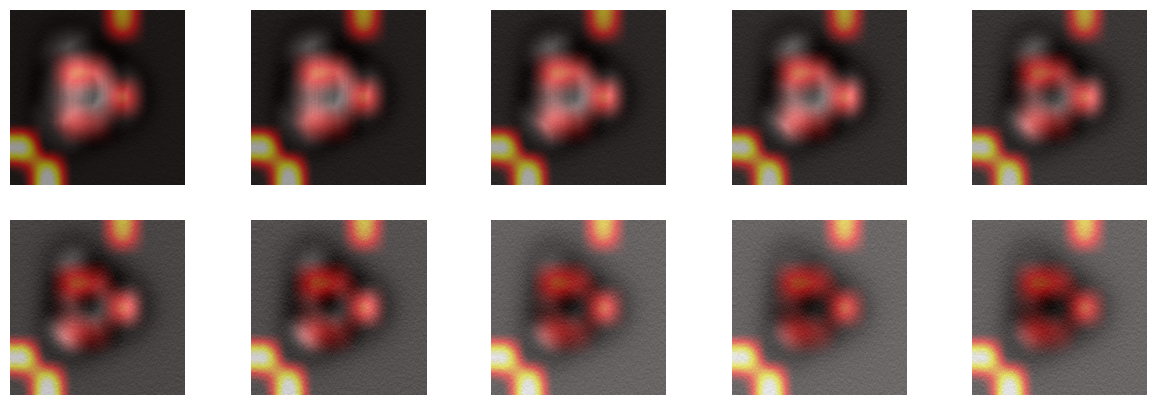

In [14]:
THRESHOLD = 0.9
ALPHA = 0.5
ZOOM = 1

path = '../../data/EXPERIMENTAL_IMAGES/RAW/1-Bromo-3,5-dichlorobenzene'

exp_img, heatmap = compute_gradcam_figure(path, zoom = ZOOM, threshold = THRESHOLD)

#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')


for i in range(2):
    for j in range(5):
        axarr[i,j].axis('off')
        axarr[i,j].imshow(heatmap, cmap='hot', alpha=ALPHA)